___
### Import libraries and sub-libraries.

In [14]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import tifffile 
from skimage.metrics import structural_similarity as ssim

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [15]:
# from fontsetting import font_cmu
# plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)
is_cuda = device.type == 'cuda'

Device available: cuda


___
### Read training data from `data/train-clean-tif`
### Read validaiton data from `data/val-clean-tif`


In [17]:
# Loading TIFF images
class TIFFDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = [f for f in os.listdir(directory) if f.endswith('.tif')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.filenames[idx])
        image = Image.open(img_path)
        if self.transform: # Dynamically apply data transformation
            image = self.transform(image)
        return image

# Create a transform to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create a transform to convert the images to PyTorch tensors and perform data augmentation on the training images
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0,translate=(0.1,0.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Create the dataset for training and validation images
train_dataset = TIFFDataset('train-clean-tif', transform=train_transform)
val_dataset = TIFFDataset('val-clean-tif', transform=transform) # Create the dataset for validation images

# Function to create data loader
def create_loader(train_dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility of random numbers in PyTorch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Creates a training DataLoader from this Dataset
    return train_loader

dataset_size = len(train_dataset), len(val_dataset)
print('Number of images in the training dataset:', dataset_size[0])
print('Number of images in the validation dataset:', dataset_size[1])


Number of images in the training dataset: 52
Number of images in the validation dataset: 16


### Define a denoising network

#### Here, I have defined a trivial network, which has only one convolutional layer and no activation function. We are essentially doing linear filtering.

In [18]:
class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [19]:
class DeNet(nn.Module):
    def __init__(self):
        super(DeNet, self).__init__()
        self.relu = nn.ReLU()
        
        # Note: dropout defined, but not used in this model
        # Encoder Section
        # layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # output 256x256
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1) # output 256x256

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output 128x128
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.2)

        # layer 2
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # output 128x128
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1) # output 128x128
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output 64x64
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(0.2)

        # layer 3
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) # output 64x64
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1) # output 64x64

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output 32x32
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(0.2)

        # layer 4
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1) # output 32x32
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1) # output 32x32

        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output 16x16
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout4 = nn.Dropout(0.2)
        
        # layer 5
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1) # output 16x16
        self.conv10 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1) # output 16x16

        # Decoder Section
        self.up1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2) # output 32x32
        self.bn5 = nn.BatchNorm2d(512)
        self.dropout5 = nn.Dropout(0.2)

        # layer 4
        self.conv11 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1) # output 32x32; still using 1024 channels because of concatenation
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1) # output 32x32
        
        self.up2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2) # output 64x64
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout6 = nn.Dropout(0.2)

        # layer 3
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1) # output 64x64; still using 512 channels because of concatenation
        self.conv14 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1) # output 64x64

        self.up3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2) # output 128x128
        self.bn7 = nn.BatchNorm2d(128)
        self.dropout7 = nn.Dropout(0.2)

        # layer 2
        self.conv15 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1) # output 128x128; still using 256 channels because of concatenation
        self.conv16 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1) # output 128x128

        self.up4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2) # output 256x256
        self.bn8 = nn.BatchNorm2d(64)
        self.dropout8 = nn.Dropout(0.2)

        # layer 1
        self.conv17 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1) # output 256x256; still using 128 channels because of concatenation
        self.conv18 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1) # output 256x256

        # Output layer
        self.conv19 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding=0) # output 256x256



    def forward(self, x):
        x11 = self.relu(self.conv1(x))
        x12 = self.relu(self.conv2(x11))

        x2 = self.bn1(self.pool1(x12))
        x21 = self.relu(self.conv3(x2))
        x22 = self.relu(self.conv4(x21))

        x3 = self.bn2(self.pool2(x22))
        x31 = self.relu(self.conv5(x3))
        x32 = self.relu(self.conv6(x31))

        x4 = self.bn3(self.pool3(x32))
        x41 = self.relu(self.conv7(x4))
        x42 = self.relu(self.conv8(x41))

        x5 = self.bn4(self.pool4(x42))
        x51 = self.relu(self.conv9(x5))
        x52 = self.relu(self.conv10(x51))

        x6 = self.bn5(self.up1(x52))
        x6 = torch.cat((x6, x42), dim=1)
        x61 = self.relu(self.conv11(x6))
        x62 = self.relu(self.conv12(x61))

        x7 = self.bn6(self.up2(x62))
        x7 = torch.cat((x7, x32), dim=1)
        x71 = self.relu(self.conv13(x7))
        x72 = self.relu(self.conv14(x71))

        x8 = self.bn7(self.up3(x72))
        x8 = torch.cat((x8, x22), dim=1)
        x81 = self.relu(self.conv15(x8))
        x82 = self.relu(self.conv16(x81))

        x9 = self.bn8(self.up4(x82))
        x9 = torch.cat((x9, x12), dim=1)
        x91 = self.relu(self.conv17(x9))
        x92 = self.relu(self.conv18(x91))

        x = self.conv19(x92)
        
        return x

___
### Create a function to execute training. Note, we will call this function later.

In [20]:
# define NMSE loss
def nmse_loss(output, target):
    diff = output - target
    diff_norm_squared = torch.sum(diff ** 2) ** (1/2)
    target_norm_squared = torch.sum(target ** 2) ** (1/2)
    nmse = diff_norm_squared / (target_norm_squared + 1e-8)  # Add a small constant to avoid division by zero
    return 20 * torch.log10(nmse)  # Convert to dB

In [21]:
def train_model(model, opt, criterion, train_loader, test_loader, num_epoch, noise_std, avg_train_losses=[], avg_test_losses=[], avg_nmse_tr_losses = [], avg_nmse_te_losses = [], epoch=0, save = False):

    for epoch in range(epoch, num_epoch): # Loop over the dataset multiple times
        model.train()
        total_train_loss = 0
        total_nmse_tr_loss = 0
        for i, y_tr_batch in enumerate(train_loader): # Loop over mini-batches
            if is_cuda:
                y_tr_batch = y_tr_batch.to(device) #GPU STUFF

            # Normalize y_tr_batch
            y_tr_batch_min, y_tr_batch_max = y_tr_batch.min(), y_tr_batch.max()
            y_tr_batch = (y_tr_batch - y_tr_batch_min) / (y_tr_batch_max - y_tr_batch_min)

            x_tr_batch = y_tr_batch.clone()
            noise = torch.randn_like(y_tr_batch) * noise_std
            x_tr_batch = x_tr_batch + noise

            opt.zero_grad() # delete previous gradients
            y_hat_tr_batch = model(x_tr_batch) # forward pass
            loss = criterion(y_hat_tr_batch, y_tr_batch) # compute loss
            loss.backward() # backward pass
            opt.step() # update weights
            total_train_loss += loss.item() # accumulate loss
            total_nmse_tr_loss = nmse_loss(y_hat_tr_batch, y_tr_batch).item() # accumulate nmse loss
            

        avg_train_loss = total_train_loss / len(train_loader) # compute average loss
        avg_nmse_tr_loss = total_nmse_tr_loss / len(train_loader)
        avg_train_losses.append(avg_train_loss) # accumulate average loss
        avg_nmse_tr_losses.append(avg_nmse_tr_loss)
        
        # Testing
        model.eval()
        with torch.no_grad():
            total_test_loss = 0
            total_nmse_te_loss = 0
            for i, y_te_batch in enumerate(test_loader):
                if is_cuda:
                    y_te_batch= y_te_batch.to(device)#GPU STUFF

                # Normalize y_te_batch
                y_te_batch_min, y_te_batch_max = y_te_batch.min(), y_te_batch.max()
                y_te_batch = (y_te_batch - y_te_batch_min) / (y_te_batch_max - y_te_batch_min)

                noise = torch.randn_like(y_te_batch) * noise_std
                x_te_batch = y_te_batch + noise

                y_hat_te_batch = model(x_te_batch)
                loss = criterion(y_hat_te_batch, y_te_batch)
                total_test_loss += loss.item()
                total_nmse_te_loss = nmse_loss(y_hat_te_batch, y_te_batch).item()

            avg_test_loss = total_test_loss / len(test_loader)
            avg_nmse_te_loss = total_nmse_te_loss / len(test_loader)
            print(f'Epoch {epoch+1}, Test Loss: {avg_test_loss:.6f}, Train Loss: {avg_train_loss:.6f}')
            avg_test_losses.append(avg_test_loss)
            avg_nmse_te_losses.append(avg_nmse_te_loss)

        # Save the model and optimizer state
        if (epoch + 1) % 10 == 0 and save == True:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'avg_train_losses': avg_train_losses[0:epoch],
                'avg_test_losses': avg_test_losses[0:epoch],
                'avg_nmse_tr_loss': avg_nmse_tr_losses[0:epoch],
                'avg_nmse_te_loss': avg_nmse_te_losses[0:epoch]
            }, 'Trivial.pt')

    print('Length of Training loss', len(avg_test_losses))
    print('Length of Testing loss:', len(avg_test_losses))
    print('Length of Training NMSE loss:', len(avg_nmse_tr_losses))
    print('Length of Testing NMSE loss:', len(avg_nmse_te_losses))
    print('Finished Training')
    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(10, 13))
    ax[0].plot(range(1, num_epoch+1), avg_train_losses, label='training loss')
    ax[0].plot(range(1, num_epoch+1), avg_test_losses, label='testing loss')
    ax[0].plot()
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('SSIM + L1 loss')
    ax[0].set_title('SSIM + L1 vs Epochs')
    ax[0].legend(['training accuracy', 'validation accuracy'])
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(range(1, num_epoch+1), avg_nmse_tr_losses, label='training loss')
    ax[1].plot(range(1, num_epoch+1), avg_nmse_te_losses, label='testing loss')
    ax[1].plot()
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('NMSE loss')
    ax[1].set_title('NMSE vs Epochs')
    ax[1].legend(['training accuracy', 'validation accuracy'])
    ax[1].grid(True)
    plt.tight_layout()
    plt.show()

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

In [22]:
batch_size = 1  # Number of complete images in each batch
lr = 1e-3  # Learning rate
sig = 0.1  # Noise std
num_epoch = 250  # Epochs

In [23]:
def SSIM_L1_loss(output, target):
    # print(f"Output shape: {output.shape}, Target shape: {target.shape}")  # Print the shapes of the output and target tensors

    l1_loss = nn.L1Loss()
    output_np = output.detach().cpu().numpy().squeeze()
    target_np = target.detach().cpu().numpy().squeeze()
    # print(f"Output shape: {output_np.shape}, Target shape: {target_np.shape}")  # Print the shapes of the output and target tensors
    range = np.max([output_np.max()-output_np.min(), target_np.max()-target_np.min()])
    ssim_loss = 1 - ssim(output_np.squeeze(), target_np.squeeze(), data_range=range, multichannel=True)
    ssim_loss = torch.tensor(ssim_loss, requires_grad=True).to(output.device)
    return l1_loss(output, target) + ssim_loss

In [24]:
# Initilize the model, criterion, and optimizer

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
val_loader = create_loader(val_dataset, batch_size)
model = DeNet() # Pick a model
if is_cuda:
    model = model.to(device)
opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
# criterion = nn.MSELoss() # Pick a loss function
# criterion = nmse_loss
criterion = SSIM_L1_loss
avg_train_losses = []
avg_test_losses = []
avg_nmse_tr_losses = []
avg_nmse_te_losses = []
epoch = 0

In [25]:
'''# Checks to see if there is a checkpoint file, if there is, it will load the model and optimizer state

# load in checkpoint if it exists and train
if os.path.exists('UNet_w_SSIM_L1.pt'):
    checkpoint = torch.load('UNet_w_SSIM_L1.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    avg_train_losses = checkpoint['avg_train_losses']
    avg_test_losses = checkpoint['avg_test_losses']
    epoch = checkpoint['epoch']
    # avg_nmse_tr_losses = checkpoint['avg_nmse_tr_loss']
    # avg_nmse_te_losses = checkpoint['avg_nmse_te_loss']
    avg_nmse_tr_losses = [0] * epoch
    avg_nmse_te_losses = [0] * epoch
    
    print('Model loaded from checkpoint at epoch', checkpoint['epoch'])
    print('Length of Training loss', len(avg_test_losses))
    print('Length of Testing loss:', len(avg_test_losses))
    print('Length of NMSE Training loss', len(avg_nmse_tr_losses))
    print('Length of NMSE Testing loss:', len(avg_nmse_te_losses))'''

"# Checks to see if there is a checkpoint file, if there is, it will load the model and optimizer state\n\n# load in checkpoint if it exists and train\nif os.path.exists('UNet_w_SSIM_L1.pt'):\n    checkpoint = torch.load('UNet_w_SSIM_L1.pt')\n    model.load_state_dict(checkpoint['model_state_dict'])\n    opt.load_state_dict(checkpoint['optimizer_state_dict'])\n    avg_train_losses = checkpoint['avg_train_losses']\n    avg_test_losses = checkpoint['avg_test_losses']\n    epoch = checkpoint['epoch']\n    # avg_nmse_tr_losses = checkpoint['avg_nmse_tr_loss']\n    # avg_nmse_te_losses = checkpoint['avg_nmse_te_loss']\n    avg_nmse_tr_losses = [0] * epoch\n    avg_nmse_te_losses = [0] * epoch\n    \n    print('Model loaded from checkpoint at epoch', checkpoint['epoch'])\n    print('Length of Training loss', len(avg_test_losses))\n    print('Length of Testing loss:', len(avg_test_losses))\n    print('Length of NMSE Training loss', len(avg_nmse_tr_losses))\n    print('Length of NMSE Testing l

Epoch 1, Test Loss: 0.257639, Train Loss: 0.439356
Epoch 2, Test Loss: 0.237397, Train Loss: 0.282508
Epoch 3, Test Loss: 0.224066, Train Loss: 0.262024
Epoch 4, Test Loss: 0.226595, Train Loss: 0.241114
Epoch 5, Test Loss: 0.204149, Train Loss: 0.232086
Epoch 6, Test Loss: 0.207984, Train Loss: 0.213554
Epoch 7, Test Loss: 0.188330, Train Loss: 0.208539
Epoch 8, Test Loss: 0.189377, Train Loss: 0.203198
Epoch 9, Test Loss: 0.188511, Train Loss: 0.210259
Epoch 10, Test Loss: 0.192847, Train Loss: 0.195409
Epoch 11, Test Loss: 0.204579, Train Loss: 0.199665
Epoch 12, Test Loss: 0.186928, Train Loss: 0.184861
Epoch 13, Test Loss: 0.196636, Train Loss: 0.184552
Epoch 14, Test Loss: 0.202222, Train Loss: 0.185667
Epoch 15, Test Loss: 0.198851, Train Loss: 0.188988
Epoch 16, Test Loss: 0.172880, Train Loss: 0.176374
Epoch 17, Test Loss: 0.176909, Train Loss: 0.177792
Epoch 18, Test Loss: 0.178652, Train Loss: 0.171180
Epoch 19, Test Loss: 0.202635, Train Loss: 0.178297
Epoch 20, Test Loss: 

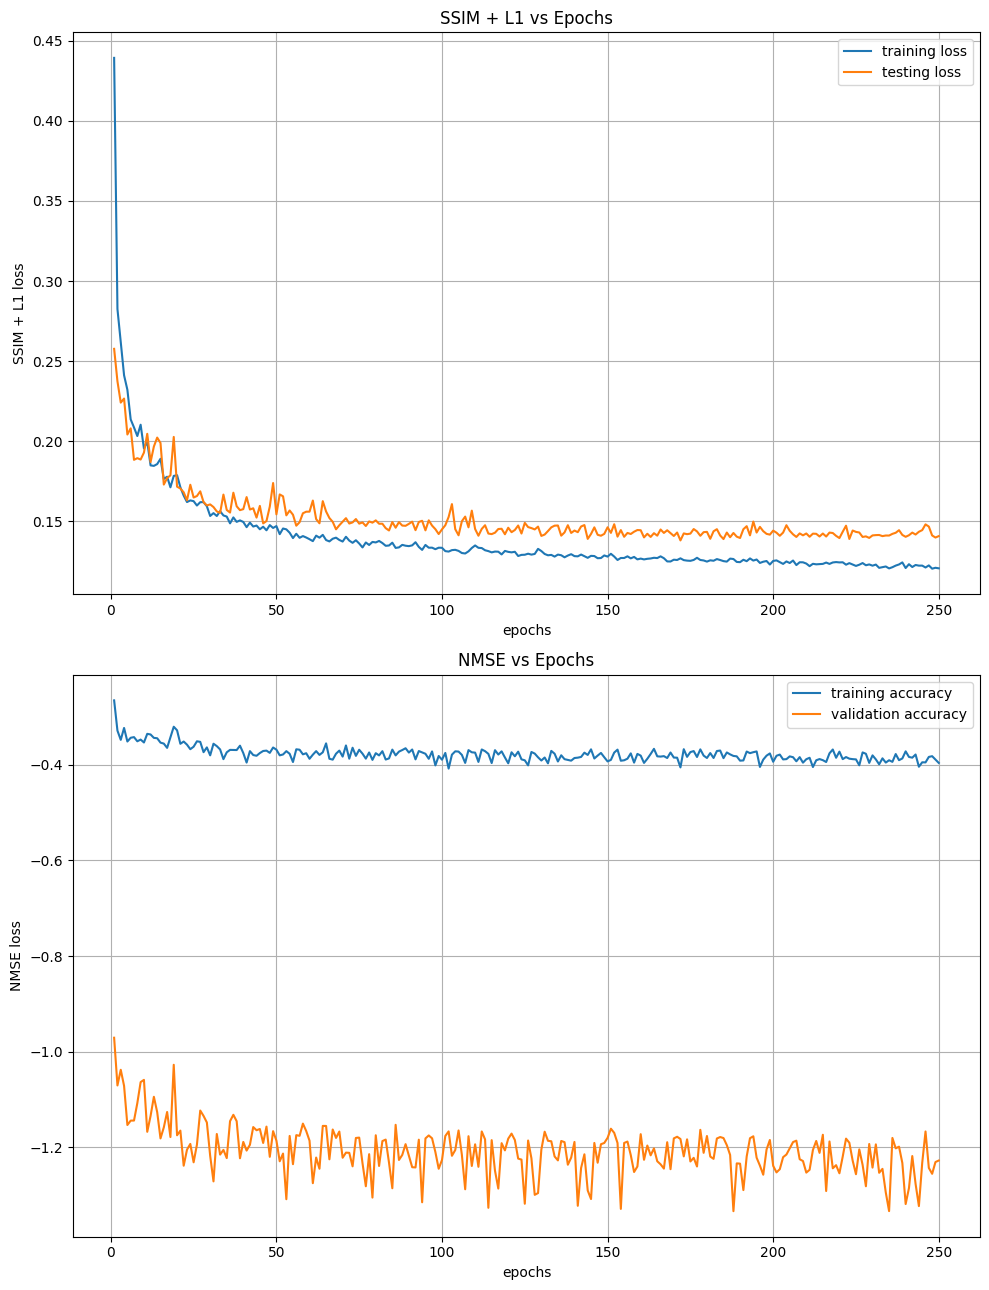

In [26]:
# train model (from scratch or a checkpoint)
train_model(model, opt, criterion, train_loader, val_loader, num_epoch, sig, avg_train_losses, avg_test_losses, avg_nmse_tr_losses, avg_nmse_te_losses, epoch, save = True)

___
### Train trivialNet

In [27]:
batch_size = 1  # Number of complete images in each batch
lr = 1e-3  # Learning rate
sig = 0.1  # Noise std
num_epoch = 100  # Epochs

In [28]:
# Initilize the model, criterion, and optimizer

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
val_loader = create_loader(val_dataset, batch_size)
trivial_model = TrivialNet() # Pick a model
if is_cuda:
    trivial_model = trivial_model.to(device)
opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
# criterion = nn.MSELoss() # Pick a loss function
# criterion = nmse_loss
criterion = nn.MSELoss() # Pick a loss function
avg_train_losses = []
avg_test_losses = []
avg_nmse_tr_losses = []
avg_nmse_te_losses = []
epoch = 0

Epoch 1, Test Loss: 0.061991, Train Loss: 0.060049
Epoch 2, Test Loss: 0.062015, Train Loss: 0.059864
Epoch 3, Test Loss: 0.061992, Train Loss: 0.059611
Epoch 4, Test Loss: 0.061989, Train Loss: 0.060113
Epoch 5, Test Loss: 0.062005, Train Loss: 0.059852
Epoch 6, Test Loss: 0.062001, Train Loss: 0.059834
Epoch 7, Test Loss: 0.061999, Train Loss: 0.060221
Epoch 8, Test Loss: 0.061995, Train Loss: 0.059924
Epoch 9, Test Loss: 0.062005, Train Loss: 0.059756
Epoch 10, Test Loss: 0.061993, Train Loss: 0.060005
Epoch 11, Test Loss: 0.061992, Train Loss: 0.060135
Epoch 12, Test Loss: 0.062011, Train Loss: 0.059757
Epoch 13, Test Loss: 0.061991, Train Loss: 0.060414
Epoch 14, Test Loss: 0.061987, Train Loss: 0.060405
Epoch 15, Test Loss: 0.062016, Train Loss: 0.060218
Epoch 16, Test Loss: 0.061998, Train Loss: 0.059421
Epoch 17, Test Loss: 0.062000, Train Loss: 0.059253
Epoch 18, Test Loss: 0.061990, Train Loss: 0.060205
Epoch 19, Test Loss: 0.061997, Train Loss: 0.059645
Epoch 20, Test Loss: 

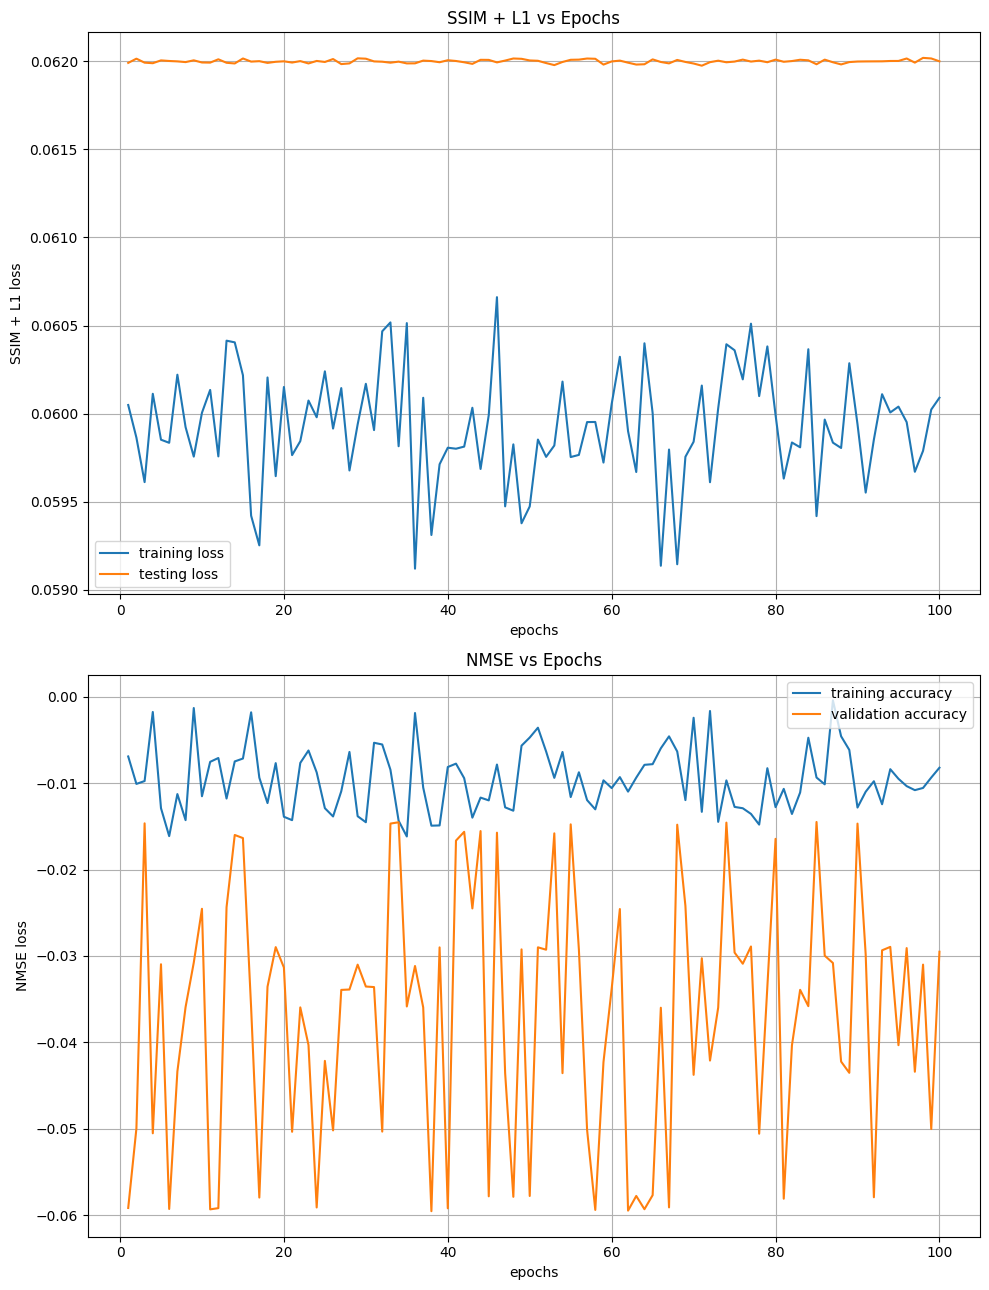

In [29]:
train_model(trivial_model, opt, criterion, train_loader, val_loader, num_epoch, sig, avg_train_losses, avg_test_losses, avg_nmse_tr_losses, avg_nmse_te_losses, epoch, save = False)

___
### Apply it to one of the validation image

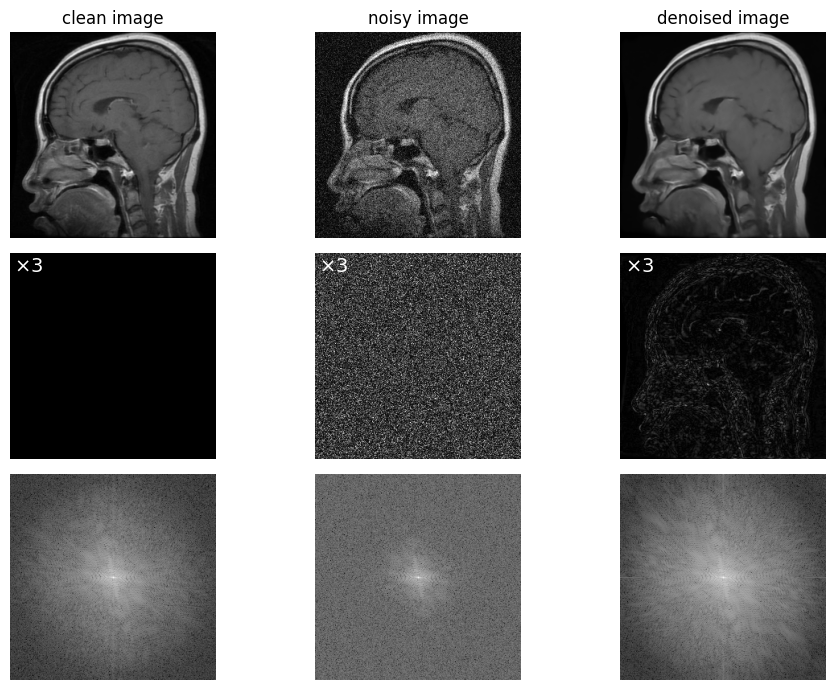

In [30]:
val_dataset = TIFFDataset('val-clean-tif', transform=transform) # Create the dataset for validation images
val_clean = val_dataset[0] # Load one clean image from the validation dataset
val_noisy = val_clean + (torch.randn_like(val_clean) * sig) # Add noise to the clean image
# val_denoised = model(val_noisy).detach() # Denoise the noisy image using the trained model
# val_clean_fft = torch.fft.fft2(val_clean)
val_noisy_4d = val_noisy.unsqueeze(0) # Add an extra dimension to represent the batch size
if is_cuda:
    val_noisy_4d=val_noisy_4d.to(device)
val_denoised = model(val_noisy_4d).detach() # Now pass this 4D tensor to the model
if is_cuda:
    val_denoised=val_denoised.cpu()

# Remove the batch dimension before further processing
val_denoised = val_denoised.squeeze(0)
val_clean_FFT = np.fft.fftn(val_clean)
val_noisy_fft = torch.fft.fftn(val_noisy)
val_denoised_fft = torch.fft.fftn(val_denoised)


# Your existing code to generate the figure and axes
fig, ax = plt.subplots(3, 3, figsize=(10, 7))

# Plot clean image
ax[0, 0].imshow(np.abs(val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('clean image')
ax[0, 0].axis('off')

# Plot noisy image
ax[0, 1].imshow(np.abs(val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('noisy image')
ax[0, 1].axis('off')

# Plot denoised image
ax[0, 2].imshow(np.abs(val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('denoised image')
ax[0, 2].axis('off')

# Plot corresponding error images
ax[1, 0].imshow(3*np.abs(val_clean - val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(3*np.abs(val_clean - val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(3*np.abs(val_clean - val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')

# Plot the Fourier transform of the clean image
ax[2, 0].imshow(np.log(np.abs(np.fft.fftshift(val_clean_FFT.squeeze()))**2), cmap='gray')
ax[2, 0].axis('off')

# Plot the Fourier transform of the noisy image
ax[2, 1].imshow(np.log(np.abs(np.fft.fftshift(val_noisy_fft.squeeze()))**2), cmap='gray')
ax[2, 1].axis('off')

# Plot the Fourier transform of the denoised image
ax[2, 2].imshow(np.log(np.abs(np.fft.fftshift(val_denoised_fft.squeeze()))**2), cmap='gray')
ax[2, 2].axis('off')


plt.tight_layout()
plt.show()


___
### Compare images for Trivial Net vs DeNet

Text(0.02, 0.98, '$\\times 3$')

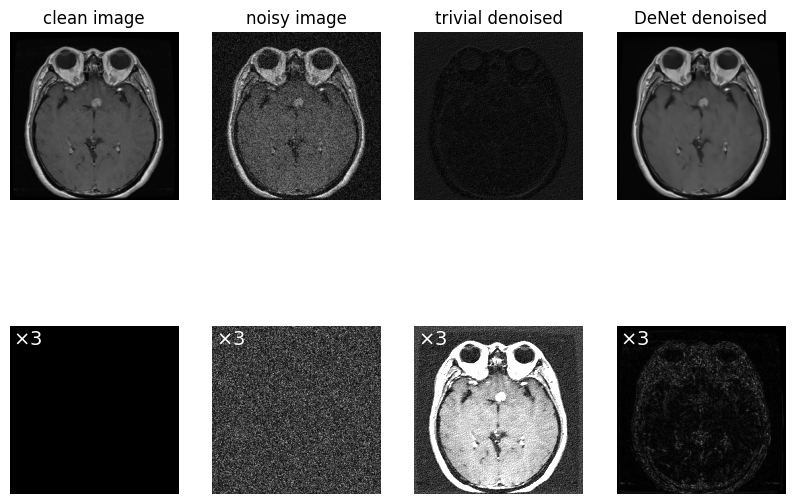

In [31]:
test_dataset = TIFFDataset('test-clean-tif', transform=transform) # Create the dataset for test images
test_clean = test_dataset[0] # Load one clean image from the test dataset
test_noisy = test_clean + (torch.randn_like(test_clean) * sig) # Add noise to the clean image
# test_denoised = model(test_noisy).detach() # Denoise the noisy image using the trained model
test_noisy_4d = test_noisy.unsqueeze(0) # Add an extra dimension to represent the batch size
if is_cuda:
    test_noisy_4d=test_noisy_4d.to(device)
    test_noisy=test_noisy.to(device)
test_denoised = model(test_noisy_4d).detach() # Now pass this 4D tensor to the model
test_denoised = test_denoised.squeeze(0) # Remove the batch dimension before further processing
test_denoised_trivial = trivial_model(test_noisy).detach() # Denoise the noisy image using the trained model
if is_cuda:
    test_denoised=test_denoised.cpu()
    test_noisy=test_noisy.cpu()
    test_denoised_trivial=test_denoised_trivial.cpu()

    


# Your existing code to generate the figure and axes
fig, ax = plt.subplots(2, 4, figsize=(10, 7))

# Plot clean image
ax[0, 0].imshow(np.abs(test_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('clean image')
ax[0, 0].axis('off')

# Plot noisy image
ax[0, 1].imshow(np.abs(test_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('noisy image')
ax[0, 1].axis('off')

# Plot denoised image TrivialNet
ax[0, 2].imshow(np.abs(test_denoised_trivial).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('trivial denoised')
ax[0, 2].axis('off')

# Plot denoised image DeNet
ax[0, 3].imshow(np.abs(test_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 3].set_title('DeNet denoised')
ax[0, 3].axis('off')


# Plot corresponding error images
ax[1, 0].imshow(3*np.abs(test_clean - test_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(3*np.abs(test_clean - test_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(3*np.abs(test_clean - test_denoised_trivial).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 3].imshow(3*np.abs(test_clean - test_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 3].axis('off')
ax[1, 3].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 3].transAxes, fontsize=14, va='top', ha='left', color='white')

In [32]:
def evaluate_nmse(loader, model, loss, name):
    criterion = loss
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, y_batch in enumerate(loader):
            if is_cuda:
                y_batch = y_batch.to(device)

            noise = torch.randn_like(y_batch) * sig
            x_batch = y_batch + noise

            y_hat_batch = model(x_batch)
            loss = criterion(y_hat_batch, y_batch)
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        print(f'Average {name} NMSE loss: {avg_loss:.6f}')

        return avg_loss

def evaluate_ssim(loader, model, loss, name):
        total_ssim = 0
        criterion = ssim
        with torch.no_grad():  # Disable gradient calculation for efficiency
            for i, val_batch in enumerate(loader):
                if is_cuda:
                    val_batch = val_batch.to(device)
                noisy_batch = val_batch + (torch.randn_like(val_batch) * sig)
                denoised_batch = model(noisy_batch)
                val_batch = val_batch.cpu().squeeze().numpy()
                noisy_batch = noisy_batch.cpu().squeeze().numpy()
                denoised_batch = denoised_batch.cpu().squeeze().numpy()
                ssim_val = ssim(val_batch, denoised_batch, data_range=1)
                total_ssim += ssim_val
        ssim_val = total_ssim / len(loader)
        print(f'Average {name} SSIM loss: {ssim_val:.6f}')



def evaluate_nmse_no_denoise(loader, loss, name):
    criterion = loss
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, y_batch in enumerate(loader):
            if is_cuda:
                y_batch = y_batch.to(device)

            noise = torch.randn_like(y_batch) * sig
            x_batch = y_batch + noise

            # y_hat_batch = model(x_batch)
            loss = criterion(x_batch, y_batch)
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        print(f'Average {name} NMSE loss: {avg_loss:.6f}')

        return avg_loss

def evaluate_ssim_no_denoise(loader, loss, name):
        total_ssim = 0
        criterion = ssim
        with torch.no_grad():  # Disable gradient calculation for efficiency
            for i, val_batch in enumerate(loader):
                if is_cuda:
                    val_batch = val_batch.to(device)
                noisy_batch = val_batch + (torch.randn_like(val_batch) * sig)
                # denoised_batch = model(noisy_batch)
                val_batch = val_batch.cpu().squeeze().numpy()
                noisy_batch = noisy_batch.cpu().squeeze().numpy()
                # denoised_batch = denoised_batch.squeeze().numpy()
                ssim_val = ssim(val_batch, noisy_batch, data_range=1)
                total_ssim += ssim_val
        ssim_val = total_ssim / len(loader)
        print(f'Average {name} SSIM loss: {ssim_val:.6f}')

In [34]:
val_dataset = TIFFDataset('val-clean-tif', transform=transform) # Create the dataset for validation images
val_loader = create_loader(val_dataset, len(val_dataset))

test_dataset = TIFFDataset('test-clean-tif', transform=transform) # Create the dataset for test images
test_loader = create_loader(test_dataset, len(test_dataset))

train_dataset = TIFFDataset('train-clean-tif', transform=transform) # Create the dataset for training images
train_loader = create_loader(train_dataset, len(train_dataset))

# Evaluate NMSE and SSIM with no denoising:
evaluate_nmse_no_denoise(train_loader, nmse_loss, 'training no denoising')
evaluate_ssim_no_denoise(train_loader, ssim, 'training no denoising')
evaluate_nmse_no_denoise(val_loader, nmse_loss, 'validation no denoising')
evaluate_ssim_no_denoise(val_loader, ssim, 'validation no denoising')
evaluate_nmse_no_denoise(test_loader, nmse_loss, 'test no denoising')
evaluate_ssim_no_denoise(test_loader, ssim, 'test no denoising')

# Evaluate NMSE and SSIM with denoising from Trivial Net:
evaluate_nmse(train_loader, trivial_model, nmse_loss, 'training with Trivial Net')
evaluate_ssim(train_loader, trivial_model, ssim, 'training with Trivial Net')
evaluate_nmse(val_loader, trivial_model, nmse_loss, 'validation with Trivial Net')
evaluate_ssim(val_loader, trivial_model, ssim, 'validation with Trivial Net')
evaluate_nmse(test_loader, trivial_model, nmse_loss, 'test with Trivial Net')
evaluate_ssim(test_loader, trivial_model, ssim, 'test with Trivial Net')

# Evaluate NMSE and SSIM with denoising from DeNet:
evaluate_nmse(train_loader, model, nmse_loss, 'training with DeNet')
evaluate_ssim(train_loader, model, ssim, 'training with DeNet')
evaluate_nmse(val_loader, model, nmse_loss, 'validation with DeNet')
evaluate_ssim(val_loader, model, ssim, 'validation with DeNet')
nmse = evaluate_nmse(test_loader, model, nmse_loss, 'test with DeNet')
evaluate_ssim(test_loader, model, ssim, 'test with DeNet')


print('Test Normalized Mean Squared Error:', nmse)


Average training no denoising NMSE loss: -7.935601
Average training no denoising SSIM loss: 0.639227
Average validation no denoising NMSE loss: -8.009263
Average validation no denoising SSIM loss: 0.647057
Average test no denoising NMSE loss: -7.956191
Average test no denoising SSIM loss: 0.674077
Average training with Trivial Net NMSE loss: -0.580696
Average training with Trivial Net SSIM loss: -0.049679
Average validation with Trivial Net NMSE loss: -0.609903
Average validation with Trivial Net SSIM loss: -0.057882
Average test with Trivial Net NMSE loss: -0.522039
Average test with Trivial Net SSIM loss: -0.059171
Average training with DeNet NMSE loss: -19.698793
Average training with DeNet SSIM loss: 0.962014
Average validation with DeNet NMSE loss: -19.472027
Average validation with DeNet SSIM loss: 0.962750
Average test with DeNet NMSE loss: -19.660973
Average test with DeNet SSIM loss: 0.967844
Test Normalized Mean Squared Error: -19.660972595214844
